![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)



# DEDL - EODAG - DestinE Data Lake Provider (DEDL) 

**Author**: EUMETSAT <br>
**Copyright**: 2024 EUMETSAT <br>
**Licence**: MIT <br>

<div class="alert alert-block alert-success">
<h3>How to use EODAG to search and access DEDL data</h3> 
EODAG is a command line tool and a Python package for searching and downloading earth observation data via a unified API regardless of the data provider. Detailed information about the usage of EODAG can be found on the <a href="https://eodag.readthedocs.io/en/stable/index.html">project documentation page</a>.
    
This notebook demonstrates how to use the DEDL provider in EODAG, using Python code.
</div>

1. [Setup](#EOSetup): *EODAG* configuration to use the provider *DEDL* .
2. [Search](#DataSearch): search *DEDL* data, we search for Sentinel-3 data.
3. [Filter](#Filter): filter *DEDL* data. 
4. [Download](#DataDownload): download *DEDL* data.

The complete guide on how to use EODAG Python API is available via https://eodag.readthedocs.io/en/stable/api_user_guide.html.

<div class="alert alert-block alert-warning">
<b> Prequisites: </b>
For search and download dedl products : <a href="https://platform.destine.eu/"> DestinE user account</a>
</div>

<div class="alert alert-block alert-warning">
<b> Note:</b>
    
Please note that the two factor authentication (2FA) is still not implemented in EODAG. The users who have enabled 2FA on DESP will not be able to run this notebook.
</div>

## EOSetup
In this section, we set:
- The output_dir, the directory where to store downloaded products.
- The DEDL credentials, you'll be asked to enter your DEDL credentials.
- The search timeout, it is of 60 seconds to avoid any unexpected errors because of long running search queries. 

In [45]:
import os
from getpass import getpass

workspace = 'eodag_workspace'
if not os.path.isdir(workspace):
    os.mkdir(workspace)
    
#os.environ["EODAG__DEDL__DOWNLOAD__OUTPUT_DIR"] = os.path.abspath(workspace)
os.environ["EODAG__DEDL__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)

os.environ["EODAG__DEDL__PRIORITY"]="10"
os.environ["EODAG__DEDL__SEARCH__TIMEOUT"]="60"


DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

os.environ["EODAG__DEDL__AUTH__CREDENTIALS__USERNAME"]=DESP_USERNAME
os.environ["EODAG__DEDL__AUTH__CREDENTIALS__PASSWORD"]=DESP_PASSWORD


Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


### Import EODAG and list available products on DEDL

We now need to import the EODataAccessGateway class. The class is going to take care of  all the following operations.

We can start listing the products available using dedl as provider.

In [46]:

from eodag import EODataAccessGateway
dag = EODataAccessGateway()

In [47]:
[product_type["ID"] for product_type in dag.list_product_types("dedl")]

['EO.CLMS.DAT.CORINE',
 'EO.CLMS.DAT.GLO.DMP300_V1',
 'EO.CLMS.DAT.GLO.FAPAR300_V1',
 'EO.CLMS.DAT.GLO.FCOVER300_V1',
 'EO.CLMS.DAT.GLO.GDMP300_V1',
 'EO.CLMS.DAT.GLO.LAI300_V1',
 'EO.CLMS.DAT.GLO.NDVI300_V1',
 'EO.CLMS.DAT.GLO.NDVI_1KM_V2',
 'EO.CLMS.DAT.SENTINEL-2.HRVPP.VI',
 'EO.DEM.DAT.COP-DEM_GLO-30-DGED',
 'EO.DEM.DAT.COP-DEM_GLO-30-DTED',
 'EO.DEM.DAT.COP-DEM_GLO-90-DGED',
 'EO.DEM.DAT.COP-DEM_GLO-90-DTED',
 'EO.ECMWF.DAT.CAMS_EUROPE_AIR_QUALITY_FORECASTS',
 'EO.ECMWF.DAT.CAMS_EUROPE_AIR_QUALITY_REANALYSES',
 'EO.ECMWF.DAT.CAMS_GLOBAL_ATMOSHERIC_COMPO_FORECAST',
 'EO.ECMWF.DAT.CAMS_GLOBAL_EMISSION_INVENTORIES',
 'EO.ECMWF.DAT.CAMS_GLOBAL_FIRE_EMISSIONS_GFAS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_GREENHOUSE_GAS_REANALYSIS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_GREENHOUSE_GAS_REANALYSIS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_GREENHOUSE_GAS_REANALYSIS_MONTHLY_AV_FIELDS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_GREENHOUSE_GAS_REANALYSIS_MONTHLY_AV_FIELDS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_RADIATIVE_FORCING',
 'EO.ECMWF.DAT.CAMS_GL

## DataSearch

To search we use the *search* method. 
This method returns a *SearchResult* object that stores the products obtained from a given page (default: page=1) and a given maximum number of items per page (default: items_per_page=20). The parameter items_per_page can be set to a higher value, or, the search_all() method can be used instead.

In the following cell we define the search criteria.

In [48]:
search_criteria = {
    "provider":"dedl",
    "productType": "EO.EUM.DAT.SENTINEL-3.SL_1_RBT___",
    "start": "2024-07-06",
    "end": "2024-07-08",
    "geom": {"lonmin": 14.5, "latmin": 37, "lonmax": 15.5, "latmax": 38},
    "count": True
}

In [49]:
products_first_page = dag.search(**search_criteria)

Results are stored in a 'SearchResult' object that contains the details on the single search result.

In [50]:
products_first_page

SearchResult([EOProduct(id=S3B_SL_1_RBT____20240706T090728_20240706T091028_20240706T111205_0179_095_050_2340_PS2_O_NR_004, provider=dedl),
              EOProduct(id=S3B_SL_1_RBT____20240706T090728_20240706T091028_20240707T004250_0179_095_050_2340_PS2_O_NT_004, provider=dedl),
              EOProduct(id=S3A_SL_1_RBT____20240706T094617_20240706T094917_20240707T191558_0179_114_193_2340_PS1_O_NT_004, provider=dedl),
              EOProduct(id=S3A_SL_1_RBT____20240706T094617_20240706T094917_20240706T115346_0179_114_193_2340_PS1_O_NR_004, provider=dedl),
              EOProduct(id=S3B_SL_1_RBT____20240706T202423_20240706T202723_20240706T224901_0179_095_057_0540_PS2_O_NR_004, provider=dedl),
              EOProduct(id=S3B_SL_1_RBT____20240706T202423_20240706T202723_20240707T102319_0179_095_057_0540_PS2_O_NT_004, provider=dedl),
              EOProduct(id=S3A_SL_1_RBT____20240706T210311_20240706T210611_20240706T233213_0179_114_200_0540_PS1_O_NR_004, provider=dedl),
              EOProduct(id=S3A_SL_1_RBT____20240706T210311_20240706T210611_20240708T065758_0179_114_200_0540_PS1_O_NT_004, provider=dedl),
              EOProduct(id=S3B_SL_1_RBT____20240707T084117_20240707T084417_20240707T104416_0179_095_064_2340_PS2_O_NR_004, provider=dedl),
              EOProduct(id=S3B_SL_1_RBT____20240707T084117_20240707T084417_20240707T224030_0179_095_064_2340_PS2_O_NT_004, provider=dedl),
              EOProduct(id=S3A_SL_1_RBT____20240707T092006_20240707T092306_20240708T184551_0179_114_207_2340_PS1_O_NT_004, provider=dedl),
              EOProduct(id=S3A_SL_1_RBT____20240707T092006_20240707T092306_20240707T112744_0179_114_207_2340_PS1_O_NR_004, provider=dedl),
              EOProduct(id=S3A_SL_1_RBT____20240707T203700_20240707T204000_20240709T061254_0179_114_214_0540_PS1_O_NT_004, provider=dedl),
              EOProduct(id=S3A_SL_1_RBT____20240707T203700_20240707T204000_20240707T230612_0179_114_214_0540_PS1_O_NR_004, provider=dedl)])

In [52]:
print(f"Got {len(products_first_page)} products and an estimated total number of {products_first_page.number_matched} products.")

Got 14 products and an estimated total number of 14 products.


It is possible to list the metadata associated with a certain product and look into them.

In [53]:
one_product = products_first_page[1]
one_product.properties.keys()

dict_keys(['alias', 'abstract', 'instrument', 'platform', 'platformSerialIdentifier', 'processingLevel', 'keywords', 'sensorType', 'license', 'title', 'missionStartDate', '_id', 'productType', 'publicationDate', 'orbitNumber', 'orbitDirection', 'cloudCover', 'modificationDate', 'sensorMode', 'startTimeFromAscendingNode', 'completionTimeFromAscendingNode', 'id', 'downloadLink', 'thumbnail', 'storageStatus', 'defaultGeometry', 'quicklook', 'providers', 'start_datetime', 'sat:absolute_orbit', 'sar:product_type', 'dedl:baselineCollection', 'dedl:landCover', 'dedl:uid', 'dedl:endingDateTime', 'dedl:timeliness', 'dedl:freshInlandWaterCover', 'dedl:processorVersion', 'dedl:alias', 'dedl:productIdentifier', 'dedl:coastalCover', 'dedl:salineWaterCover', 'dedl:beginningDateTime', 'dedl:tidalRegionCover', 'dedl:cycleNumber', 'dedl:scope'])

In [54]:
one_product.location

'https://hda.data.destination-earth.eu/stac/collections/EO.EUM.DAT.SENTINEL-3.SL_1_RBT___/items/S3B_SL_1_RBT____20240706T090728_20240706T091028_20240707T004250_0179_095_050_2340_PS2_O_NT_004/download?provider=dedl'

In [55]:
one_product.properties['abstract']

'The SLSTR level 1 products contain: the radiances of the 6 visible (VIS), Near Infra-Red (NIR) and Short Wave Infra-Red (SWIR) bands (on the A and B stripe grids); the Brightness Temperature (BT) for the 3 Thermal Infra-Red (TIR) bands; the BT for the 2 Fire (FIR) bands. Resolution: 1km at nadir (TIR), 500m (VIS). All are provided for both the oblique and nadir view. These measurements are accompanied with grid and time information, quality flags, error estimates and meteorological auxiliary data.\n\n- All Sentinel-3 NRT products are available at pick-up point in less than 3h\n- All Sentinel-3 Non Time Critical (NTC) products are available at pick-up point in less than 30 days.\nSentinel-3 is part of a series of Sentinel satellites, under the umbrella of the EU Copernicus programme.'

In [56]:
one_product.properties['dedl:landCover']

34.441319

## Filter

EODAG can filter the products contained in a SearchResult object. 
Products can be filtered according to their properties.

The following example shows how to filter products to keep only those whose cloud cover is less than 30%. And then restrict the results to a certain area.

In [57]:
filtered_products = products_first_page.filter_property(cloudCover=20, operator="lt")
print(f"Got now {len(filtered_products)} products after filtering by cloud cover.")

Got now 10 products after filtering by cloud cover.


In [58]:
filtered_products = filtered_products.filter_overlap(geometry=(14.8, 37.7, 15, 38.0), contains=True)
print(f"Got now {len(filtered_products)} products after filtering by geometry.")

Got now 8 products after filtering by geometry.


Have a look now at the first of the fltered products.

In [59]:
filtered_products[0]

EOProduct(id=S3B_SL_1_RBT____20240706T090728_20240706T091028_20240706T111205_0179_095_050_2340_PS2_O_NR_004, provider=dedl)

## DataDownload

Before downloading any product, it can be useful to have a quick look at them.

In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

quicklooks_dir = os.path.join(workspace, "quicklooks")
if not os.path.isdir(quicklooks_dir):
    os.mkdir(quicklooks_dir)



0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

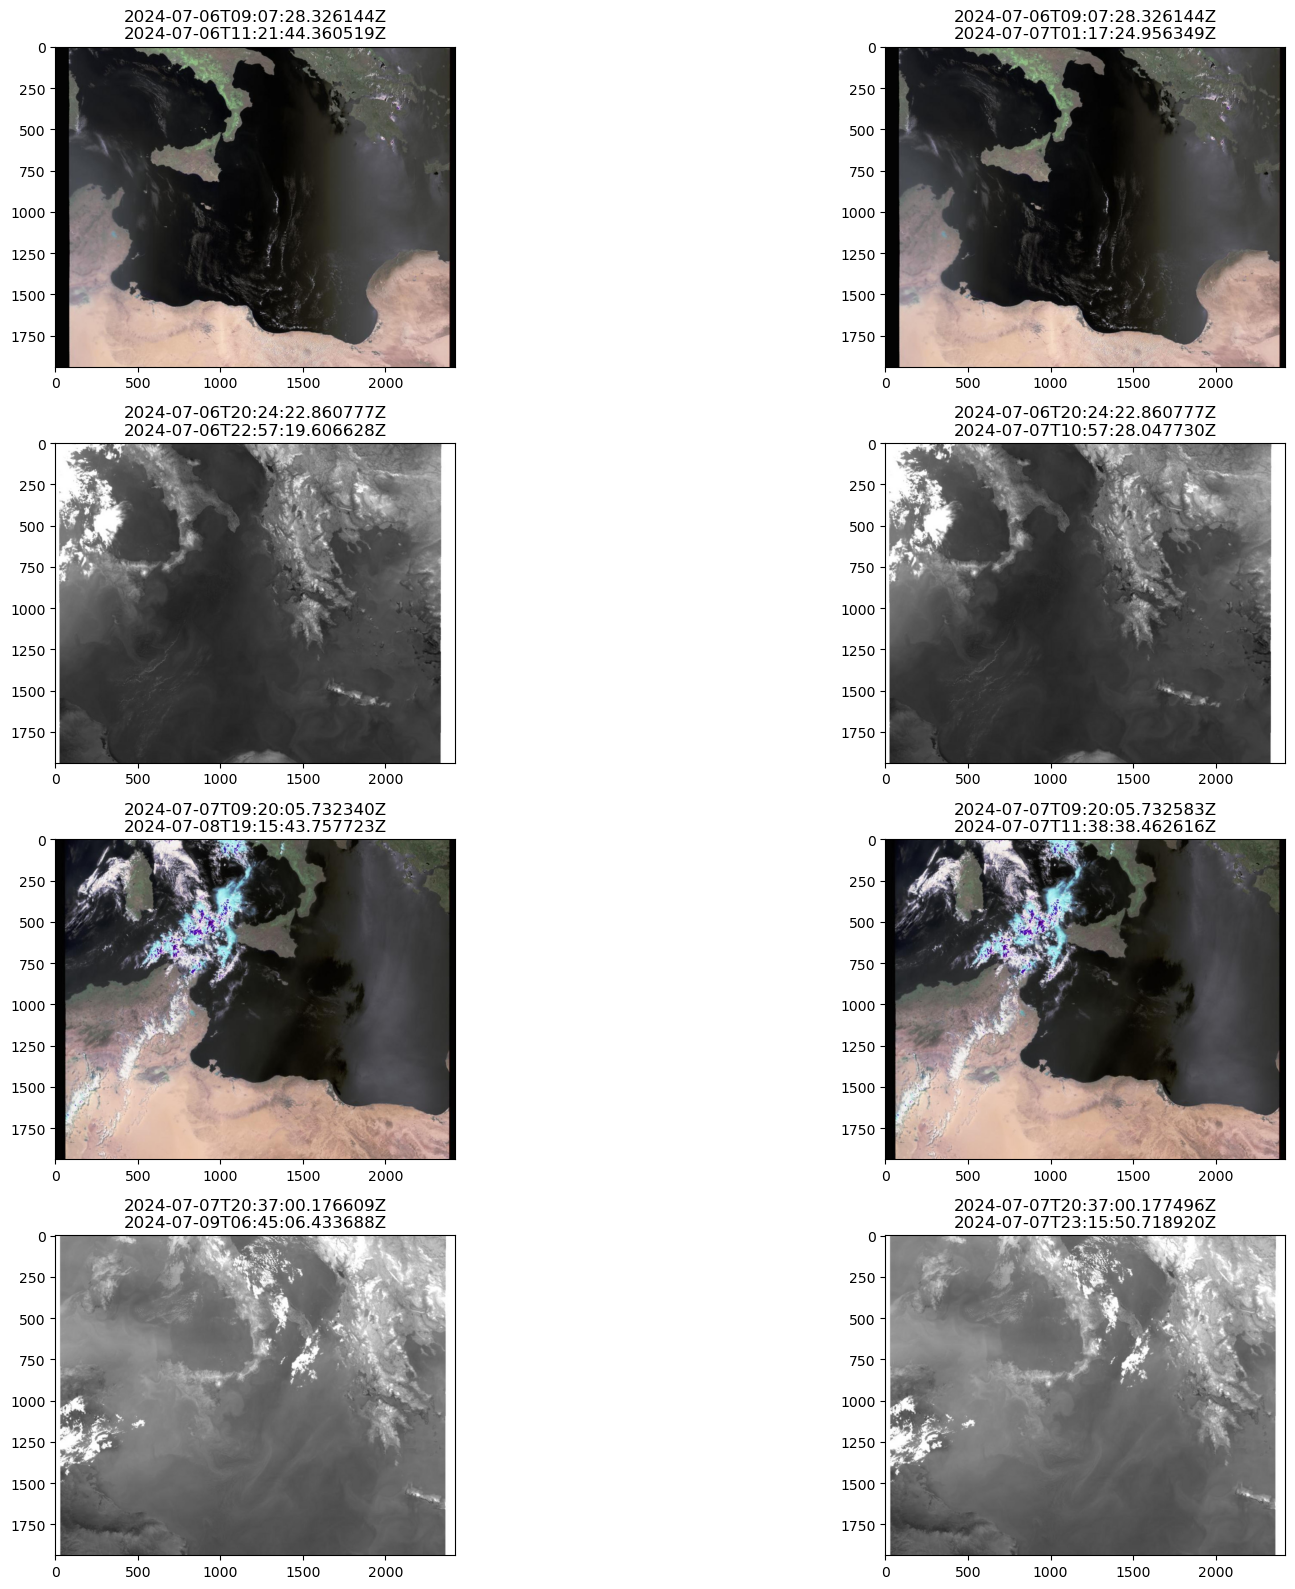

In [61]:
fig = plt.figure(figsize=(20, 16))
for i, product in enumerate(filtered_products, start=1):

    # This line takes care of downloading the quicklook
    quicklook_path = product.get_quicklook()
    
    img = mpimg.imread(quicklook_path)
    ax = fig.add_subplot(4, 2, i)
    ax.set_title(product.properties['dedl:beginningDateTime']+"\n"+product.properties['modificationDate'])
    plt.imshow(img)
plt.tight_layout()

EOProducts can be downloaded individually. The last image is going to be downloaded.

In [43]:
product_to_download = filtered_products[-1]
product_path = dag.download(product_to_download)
product_path

0.00B [00:00, ?B/s]

'/home/jovyan/dev-branch/DestinE-DataLake-Lab/HDA/EODAG/eodag_workspace/S3A_SL_1_RBT____20240707T203700_20240707T204000_20240707T230612_0179_114_214_0540_PS1_O_NR_004'

The location property of this product now points to a local path.

In [44]:
product_to_download.location

'file:///home/jovyan/dev-branch/DestinE-DataLake-Lab/HDA/EODAG/eodag_workspace/S3A_SL_1_RBT____20240707T203700_20240707T204000_20240707T230612_0179_114_214_0540_PS1_O_NR_004'